In [2]:
import pandas as pd
from numpy import mean
import numpy as np

import scipy.stats as stats
from featurewiz import FeatureWiz

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from gurobipy import Model, GRB, quicksum, max_

Imported 0.2.8 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [25]:
### DATA CLEANING AND PREPRING ###
players = pd.read_csv("england-premier-league-players-2017-to-2022-stats.csv", encoding= 'unicode_escape')
players = pd.concat([players[players['Season']=='2020-2021'],
                    players[players['Season']=='2021-2022']],axis=0)
players = players[players['appearances_overall']>0]
  
    
cols_to_drop = ['Season','shirt_number','full_name','age','birthday',
                'birthday_GMT','league','season','Current Club',
                'minutes_played_overall','minutes_played_home',
                'minutes_played_away','nationality','appearances_overall',
                'appearances_home','appearances_away']

players = players.drop(cols_to_drop,axis=1)

outfield_players = players[players['position'] != 'Goalkeeper']
goalkeepers = players[players['position'] == 'Goalkeeper']

attack_players = pd.concat([players[players['position'] == 'Foward'],
                    players[players['position'] == 'Midfielder']],axis=0)
defence_players = pd.concat([players[players['position'] == 'Midfielder'],
                    players[players['position'] == 'Defender']],axis=0)

for i in range(len(players.columns)):
    print(players.columns[i])

def extra_cleaning(X):
    # Dropping columns with NA values
    X = X.dropna(axis=1)
    
    # Checking if there is any negative values that may crash featurewiz
    more_cols_to_drop = (X<0).any()[(X<0).any()==True].index.tolist()
    X = X.drop(more_cols_to_drop,axis=1)
    
    # Checking if there is columns with only 0 that may crash featurewiz; 
    # make sure to export to csv the columns you are going to delete to check
    more_cols_to_drop = (X==0).all()[(X==0).all()==True].index.tolist()
    X = X.drop(more_cols_to_drop,axis=1)
    
    return X

position
goals_overall
goals_home
goals_away
assists_overall
assists_home
assists_away
penalty_goals
penalty_misses
clean_sheets_overall
clean_sheets_home
clean_sheets_away
conceded_overall
conceded_home
conceded_away
yellow_cards_overall
red_cards_overall
goals_involved_per_90_overall
assists_per_90_overall
goals_per_90_overall
goals_per_90_home
goals_per_90_away
min_per_goal_overall
conceded_per_90_overall
min_per_conceded_overall
min_per_match
min_per_card_overall
min_per_assist_overall
cards_per_90_overall
rank_in_league_top_attackers
rank_in_league_top_midfielders
rank_in_league_top_defenders
rank_in_club_top_scorer
average_rating_overall
assists_per_game_overall
sm_assists_total_overall
assists_per90_percentile_overall
passes_per_90_overall
passes_per_game_overall
passes_per90_percentile_overall
passes_total_overall
passes_completed_per_game_overall
passes_completed_total_overall
pass_completion_rate_percentile_overall
passes_completed_per_90_overall
passes_completed_per90_percen

In [26]:
### ANALYZING WHAT CONTRIBUTES TO GOALS (ATTACKING PLAYERS)###

cols_to_drop = ['position','goals_overall','goals_home','goals_away',
                'penalty_goals', 'penalty_misses', 'goals_per_90_overall',
                'goals_per_90_home', 'goals_per_90_away','min_per_goal_overall',
                'hattricks_total_overall','two_goals_in_a_game_total_overall',
                'three_goals_in_a_game_total_overall',
                'two_goals_in_a_game_percentage_overall',
                'three_goals_in_a_game_percentage_overall',
                'goals_involved_per90_percentile_overall',
                'goals_per90_percentile_overall', 'goals_per90_percentile_away',
                'goals_per90_percentile_home','man_of_the_match_total_overall',
                'annual_salary_eur','annual_salary_eur_percentile', 
                'annual_salary_gbp','annual_salary_usd','rank_in_league_top_attackers',
                'rank_in_league_top_midfielders','rank_in_club_top_scorer',
                'sm_goals_scored_total_overall', 'xg_per_90_overall',
                'xg_per_game_overall','xg_per90_percentile_overall',
                'goals_involved_per_90_overall', 'xg_total_overall']      ## SHOULD I INCLUDE xg_total_overall

## Need to cast target variable to float so that featurewize know it is regression.
X, y = attack_players.drop(cols_to_drop,axis=1), attack_players['goals_overall'].astype('float')

# DROPPING ROW 2323 (LITTLE WIERD)
X = X.drop(index=X.loc[2323].name)
y = y.drop(2323)

X = extra_cleaning(X)

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (390, 165)
#### Single_Label Regression problem ####
No test data filename given...
###############

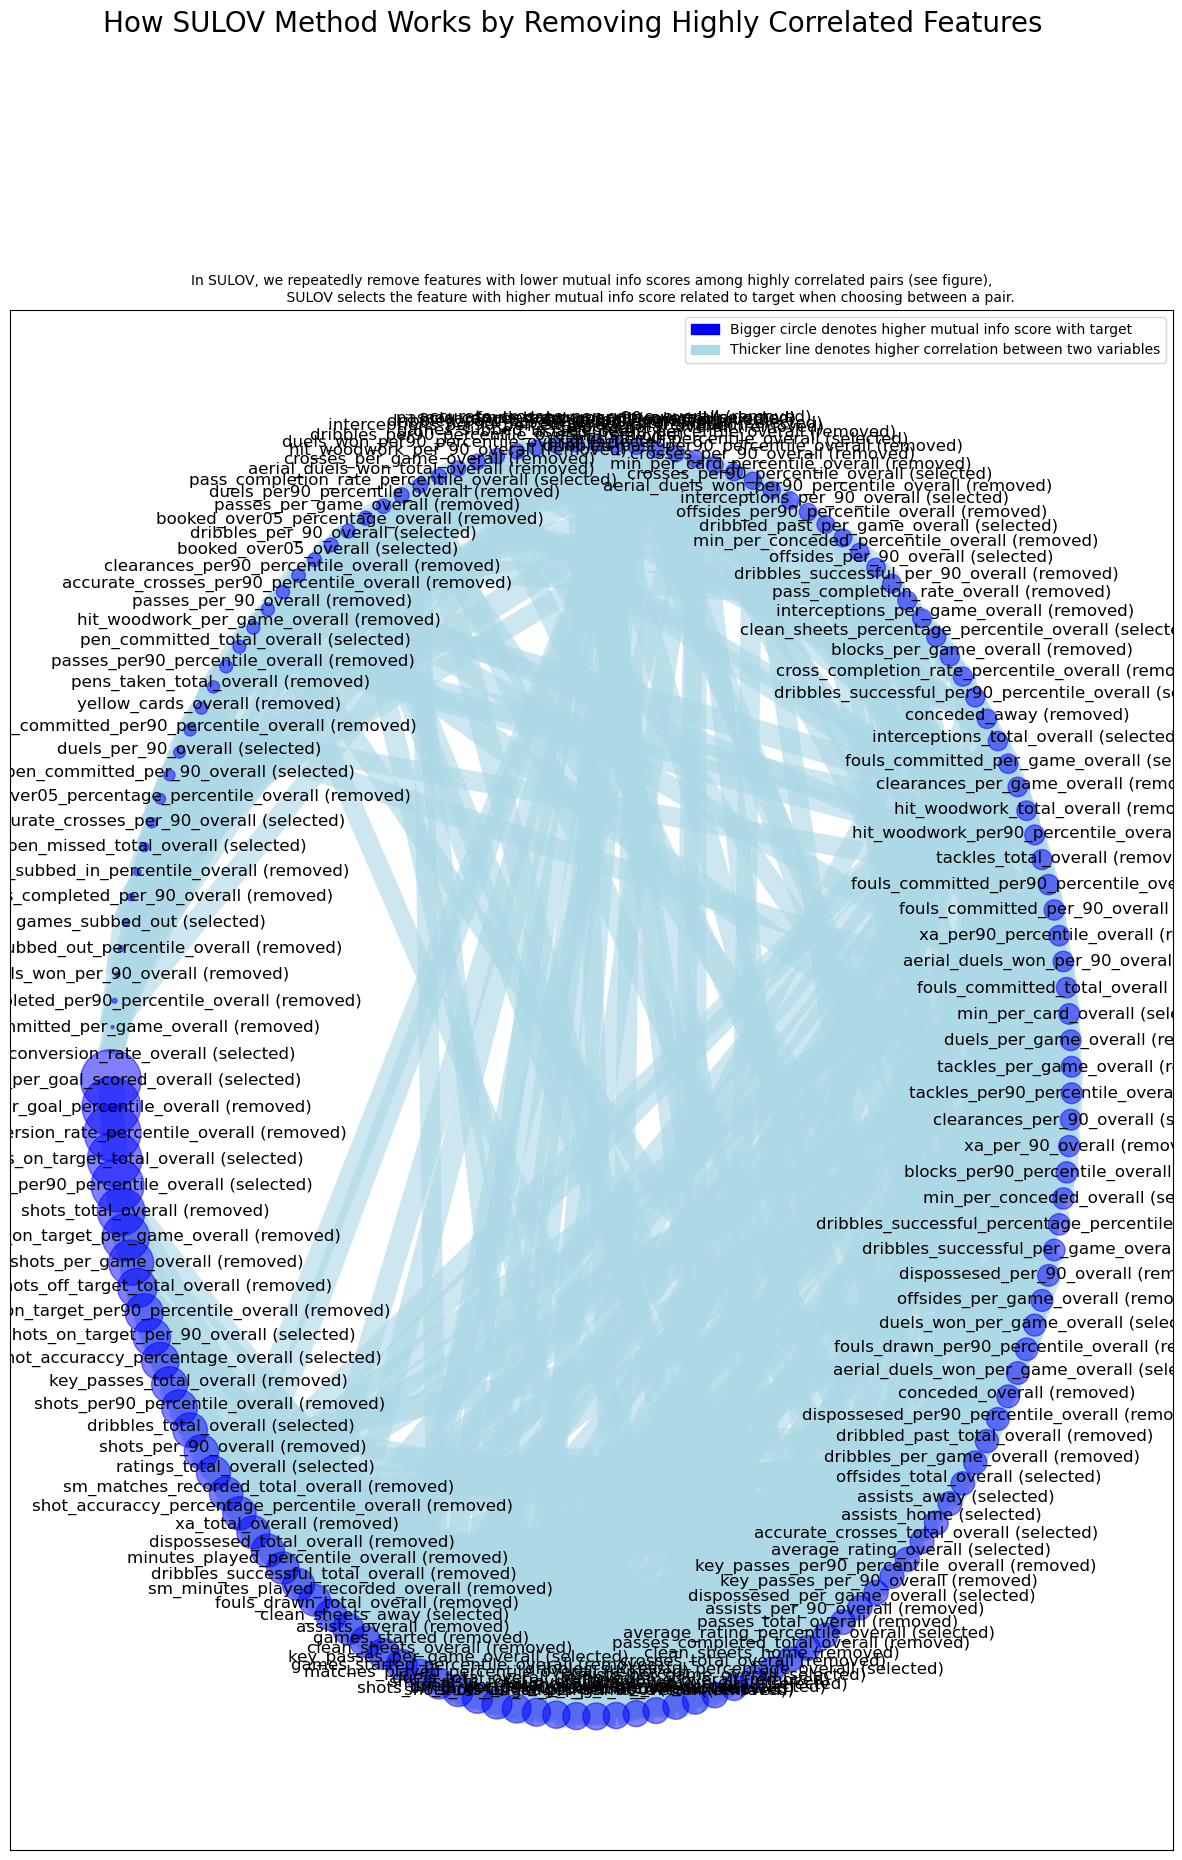

Time taken for SULOV method = 2 seconds
    Adding 0 categorical variables to reduced numeric variables  of 64
Finally 64 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 64 
    Taking top 24 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 64 variables...
            selecting 4 features in this iteration
            Time taken for regular XGBoost feature selection = 0 seconds
        using 51 variables...
            selecting 4 features in this iteration
            Time taken for regular XGBoost feature selection = 0 seconds
  

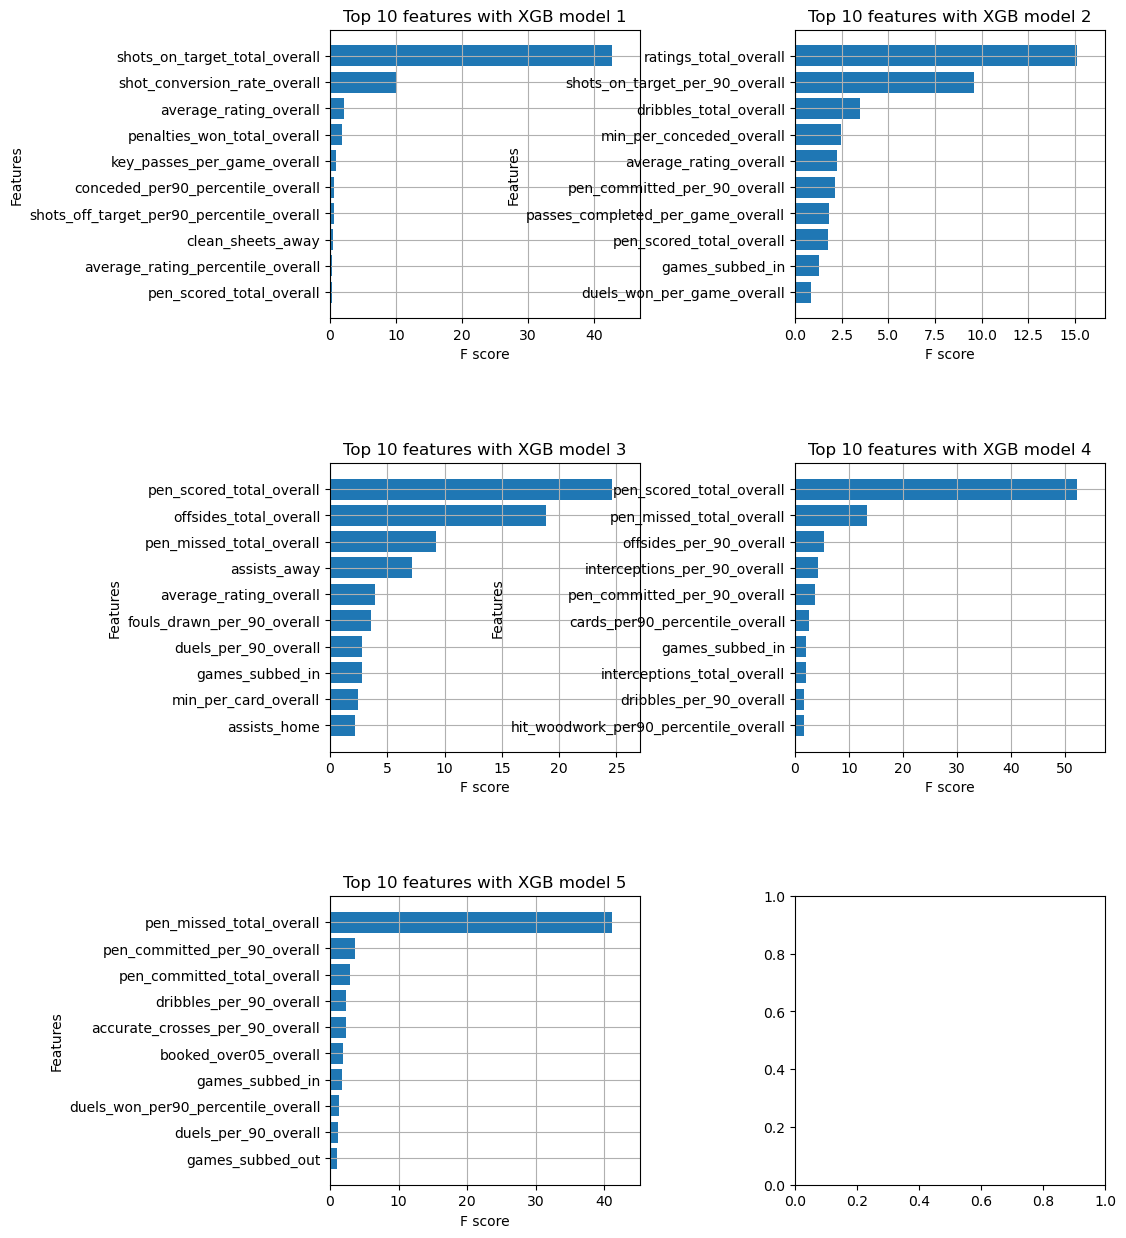

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 22 important features:
['shots_on_target_total_overall', 'shot_conversion_rate_overall', 'average_rating_overall', 'penalties_won_total_overall', 'ratings_total_overall', 'shots_on_target_per_90_overall', 'dribbles_total_overall', 'min_per_conceded_overall', 'pen_scored_total_overall', 'offsides_total_overall', 'pen_missed_total_overall', 'assists_away', 'fouls_drawn_per_90_overall', 'duels_per_90_overall', 'games_subbed_in', 'offsides_per_90_overall', 'interceptions_per_90_overall', 'pen_committed_per_90_overall', 'cards_per90_percentile_overall', 'pen_committed_total_overall', 'dribbles_per_90_overall', 'accurate_crosses_per_90_overall']
Total Time taken for featu

In [27]:
### FEATURE SELECTION ###
features = FeatureWiz(corr_limit=0.70, feature_engg='', category_encoders='', 
                      dask_xgboost_flag=False, nrows=None, verbose=2)

X_train_selected = features.fit_transform(X, y)

In [ ]:
### LINEAR REGRESSION ###
### Quick test of the usefulness of the features selected by featurewiz
def train(data, target):
    X_train, X_test,y_train, y_test = train_test_split(data, target, test_size=.2, random_state=42)# fit all models
    reg = LazyRegressor(predictions=True)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    
    return models

print(train(X_train_selected,y))

### Linear Regression on selected features

def lasso_reg_output(X,y):
    
    col_names = X.columns
    X = StandardScaler().fit_transform(X)
    lasso_CV = LassoCV(cv=5)
    lasso_CV.fit(X,y)
    
    model = Lasso(alpha=lasso_CV.alpha_)
    model.fit(X,y)

    output = {
        'Features':col_names,
        'Coef':model.coef_}
    
    return pd.DataFrame(output)

X_selected = X_train_selected

linear_model = lasso_reg_output(X_selected,y)
linear_model = linear_model.sort_values('Coef')

print(linear_model)

# If expected goal is not used then shot_conversion_rate_overall and
# shots_on_target_total_overall are the two most important features
# they have a regression cocefficient of 0.72 and 2.29 respectively.
# expected goal was removed because they aren't actions that a player 
# can control

 98%|█████████████████████████████████████████▉ | 41/42 [00:19<00:00, 17.28it/s]

In [ ]:
### ANALYZING WHAT CONTRIBUTES TO CLEAN SHEETS (DENFENDERS) ###

generic_cols_to_drop = ['position','man_of_the_match_total_overall',
                'annual_salary_eur','annual_salary_eur_percentile', 
                'annual_salary_gbp','annual_salary_usd','rank_in_league_top_attackers',
                'rank_in_league_top_midfielders','rank_in_club_top_scorer',
                'ratings_total_overall']

defence_players = defence_players.drop(generic_cols_to_drop,axis=1)

clean_sheets_cols_to_drop = ["clean_sheets_overall", "clean_sheets_home",
                             "clean_sheets_away", "conceded_overall",
                             "conceded_home", "conceded_away",
                             "xg_faced_per_90_overall",
                             "xg_faced_per90_percentile_overall",
                             "xg_faced_per_game_overall",
                             "xg_faced_total_overall",
                             'clean_sheets_percentage_percentile_overall',
                             'conceded_per_90_overall',
                             'conceded_per90_percentile_overall',
                             'min_per_conceded_overall',
                             'min_per_conceded_percentile_overall',
                             'sm_matches_recorded_total_overall',
                             'sm_matches_recorded_total_overall']  ## What is sm_matches

outcome_cols_to_drop = ['goals_overall','goals_home','goals_away',
                'penalty_goals', 'penalty_misses', 'goals_per_90_overall',
                'goals_per_90_home', 'goals_per_90_away','min_per_goal_overall',
                'hattricks_total_overall','two_goals_in_a_game_total_overall',
                'three_goals_in_a_game_total_overall',
                'two_goals_in_a_game_percentage_overall',
                'three_goals_in_a_game_percentage_overall',
                'goals_involved_per90_percentile_overall',
                'goals_per90_percentile_overall', 'goals_per90_percentile_away',
                'goals_per90_percentile_home','sm_goals_scored_total_overall', 
                'xg_per_90_overall',
                'xg_per_game_overall','xg_per90_percentile_overall',
                'goals_involved_per_90_overall', 'xg_total_overall',
                'average_rating_percentile_overall','games_subbed_in_percentile_overall',
                'games_subbed_in']

## Need to cast target variable to float so that featurewize know it is regression.
X = defence_players.drop(clean_sheets_cols_to_drop,axis=1)
X = X.drop(outcome_cols_to_drop,axis=1)
y = defence_players['clean_sheets_overall'].astype('float')

# DROPPING ROW 2323 (LITTLE WIERD)
X = X.drop(index=X.loc[2323].name)
y = y.drop(2323)

X = extra_cleaning(X)

### FEATURE SELECTION ###
features = FeatureWiz(corr_limit=0.70, feature_engg='', category_encoders='', 
                      dask_xgboost_flag=False, nrows=None, verbose=2)

X_train_selected = features.fit_transform(X, y)

### LINEAR REGRESSION ###
### Quick test of the usefulness of the features selected by featurewiz
print(train(X_train_selected,y))

### LASSO REGRESSION ###
X_selected = X_train_selected

linear_model = lasso_reg_output(X_selected,y)
linear_model = linear_model.sort_values('Coef')

print(linear_model)

# From LASSO, we see that passes_completed_total_overall (2.77), shots_total_overall (0.44),
# duels_total_overall (0.38), min_per_card_overall (0.38), assists_away (0.37) are most important
# features for predicting clean sheets.

In [28]:
### CLUSTERING ###

## Features that were selected from the player_statistical_analysis.py
selected_features = ['full_name', 'position','shot_conversion_rate_overall',
                      'shots_on_target_total_overall', 
                      'passes_completed_total_overall', 'shots_total_overall',
                      'duels_total_overall', 'min_per_card_overall',
                      'assists_away']

players_master = pd.read_csv("england-premier-league-players-2017-to-2022-stats.csv")
curr_players = players_master[players_master['Season']=='2021-2022']
curr_players = curr_players[curr_players['appearances_overall']>0]


def positions_clustering(df,position,weights,n_clusters,output=True,plot=False):
    
    df = df[df['position']==position][selected_features]
    X = df.drop(['full_name','position'],axis=1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)


    # Perform KMeans clustering and find optimal number of clusters
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    # Plot elbow curve
    if plot==True:
        plt.plot(range(1, 11), wcss)
        plt.title('Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()
    ####################################

    # Clustering of players
    n_clusters = n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    df['cluster'] = clusters
    
    # Addubg weightage the featuers to rank the players
    weights = weights
    
    df['performance'] = (X*weights).sum(axis=1)        # Used scaled data here, but should it be unscaled?
    
    df['rankings'] = [0]*len(df)    # Create a column with empty rankings
    rankings_in_cluster = {}
    for i in range(n_clusters):
        cluster_data = df[df['cluster']==i]
        cluster_data = cluster_data.sort_values(by='performance', ascending=False)
        rankings_in_cluster = cluster_data.index.values 
        
        for j in range(len(cluster_data)):
            df.loc[rankings_in_cluster[j],'rankings'] = j+1
            #curr_players.at[rankings_in_cluster[j],'rankings'] = j+1 ##added for by ranking
    
    
    
    if output == True:
        
        for i in range(n_clusters):
            print("#########################################################")
            print(f'Cluster {i}:')
            cluster_data = df[df['cluster']==i]
            names = ','.join(cluster_data['full_name'].tolist())
            print("The players in the cluster are:" + names)
            
            cluster_means = cluster_data.drop('full_name',axis=1).mean()
            print("------------------------------------------")
            print("The mean values of this cluster are:")
            print(cluster_means)
            print("------------------------------------------")
            print('Their rankings are as follows:')
            print(cluster_data.sort_values(by='rankings',ascending=True)[['full_name','performance','rankings']])
            
    return df

## Adjust the weights according to their position

weights = [0.4, 0.2, 0.2, 0.05, 0.05, 0.05, 0.05]
z1 = positions_clustering(curr_players, 'Forward', weights, 6, output=True)

weights = [0.4, 0.2, 0.2, 0.05, 0.05, 0.05, 0.05]
z2 = positions_clustering(curr_players, 'Midfielder', weights, 6, output=True)

weights = [0.4, 0.2, 0.2, 0.05, 0.05, 0.05, 0.05]
z3 = positions_clustering(curr_players, 'Defender', weights, 6,output=True)

weights = [0.4, 0.2, 0.2, 0.05, 0.05, 0.05, 0.05]
z4 = positions_clustering(curr_players, 'Goalkeeper', weights, 6,output=True)

#########################################################
Cluster 0:
The players in the cluster are:Adam Armstrong,Ademola Lookman,Alexandre Lacazette,Anthony Gordon,Armando Broja,Callum Wilson,Che Adams,Christian Benteke,Daniel James,Daniel William John Ings,Danny Welbeck,Demarai Gray,Dominic Calvert-Lewin,Francisco António Machado Mota de Castro Trincão,Gabriel Teodoro Martinelli Silva,Gnaly Maxwell Cornet,Hee-Chan Hwang,Jadon Sancho,Jamie Vardy,Jay Rodriguez,Jean-Philippe Mateta,Jordan Ayew,Joshua King,Joshua Sargent,Juan Camilo Hernández Suárez,Kelechi Iheanacho,Lucas Rodrigues Moura da Silva,Luis Díaz,Marcus Rashford,Neal Maupay,Odsonne Édouard,Patson Daka,Roberto Firmino,Rodrigo,Romelu Lukaku,Timo Werner,Wout Weghorst
------------------------------------------
The mean values of this cluster are:
shot_conversion_rate_overall      17.71
shots_on_target_total_overall     14.95
passes_completed_total_overall   331.89
shots_total_overall               29.49
duels_total_overall       

In [30]:
players= pd.concat([z1,z2,z3,z4], ignore_index = False)
players

,full_name,position,shot_conversion_rate_overall,shots_on_target_total_overall,passes_completed_total_overall,shots_total_overall,duels_total_overall,min_per_card_overall,assists_away,cluster,performance,rankings
2377,Aaron Anthony Connolly,Forward,0.00,0.00,14.00,1.00,18.00,0,0,2,-1.10,17
2383,Adam Armstrong,Forward,6.45,14.00,227.00,31.00,126.00,1414,2,0,-0.15,34
2387,Adam Uche Idah,Forward,10.00,4.00,89.00,10.00,103.00,0,0,3,-0.52,23
2389,Adama Traoré Diarra,Forward,8.33,5.00,232.00,12.00,210.00,0,0,3,-0.42,16
2390,Ademola Lookman,Forward,37.50,12.00,397.00,16.00,232.00,728,0,0,1.07,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2994,Vicente Guaita,Goalkeeper,0.00,0.00,597.00,0.00,13.00,1328,0,5,0.22,2
3003,Wayne Hennessey,Goalkeeper,0.00,0.00,33.00,0.00,2.00,0,0,0,-0.29,11
3006,Wilfredo Daniel Caballero,Goalkeeper,0.00,0.00,37.00,0.00,1.00,180,0,0,-0.29,10
3020,Zack Steffen,Goalkeeper,0.00,0.00,28.00,0.00,0.00,0,0,0,-0.31,14


In [31]:
##OPTIMIZATION
indices = players.full_name
perf = dict(zip(indices,players.performance))
player_position = list(zip(players.full_name,players.position))

# Create the model
m = Model()

# Create the decision variables
x = m.addVars(players.full_name, vtype=GRB.BINARY, name="x")

# Set the objective function
m.setObjective(quicksum(perf[i]*x[i] for i in indices), GRB.MAXIMIZE)

# Add the constraints
##user chooses salary cap

#need to add salary df
#salary_cap = 10000000
#m.addConstr(quicksum(salary[i]*y[i] for i in indices) >= salary_cap, name='salary')

m.addConstr(quicksum([x[i] for i, position in player_position if position=='Goalkeeper'])==1)

m.addConstr(quicksum([x[i] for i, position in player_position if position=='Defender'])>=3)
m.addConstr(quicksum([x[i] for i, position in player_position if position=='Defender'])<=5)

m.addConstr(quicksum([x[i] for i, position in player_position if position=='Midfielder'])>=3)
m.addConstr(quicksum([x[i] for i, position in player_position if position=='Midfielder'])<=5)

m.addConstr(quicksum([x[i] for i, position in player_position if position=='Forward'])>=1)
m.addConstr(quicksum([x[i] for i, position in player_position if position=='Forward'])<=3)

m.addConstr(quicksum(x[i] for i in indices)==11)
##add constraints for certain minimum vals on features if we want

# Solve the model
m.optimize()

r = pd.DataFrame()

for v in m.getVars():
    if v.x > 1e-6:
        r = r.append(players.iloc[v.index][['full_name','position']])
        print(v.varName) #error w unicode

        
print('Cost:', m.objVal)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 8 rows, 528 columns and 1542 nonzeros
Model fingerprint: 0x1476fa54
Variable types: 0 continuous, 528 integer (528 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 0.5964033
Presolve removed 1 rows and 56 columns
Presolve time: 0.00s
Presolved: 7 rows, 472 columns, 1416 nonzeros
Found heuristic solution: objective 18.3681362
Variable types: 0 continuous, 472 integer (466 binary)
Found heuristic solution: objective 19.0173914

Root relaxation: objective 1.911199e+01, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe3 in position 4: invalid continuation byte